<a href="https://colab.research.google.com/github/stevearonson/VB-Video-Tracking/blob/master/Detectron2_with_DeepSort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Detectron2

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 28.8MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 50.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=ceff0658808a7bf7bf4f37608ae4914070dbcdfb34941a19412a8976112f9da9
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
Successfully built fvcore


In [3]:
import numpy as np
import pandas as pd
import random

import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm 


## Access My Google Drive

In [6]:
from google.colab import drive
drive.mount('/gdrive')
base_dir = '/gdrive/My Drive/VB/Video'
!ls '/gdrive/My Drive/VB/Video'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
 Cheshire_Halasz_Perin	      demo.avi	        player_pos.csv
 Cheshire_Halasz_Perin.pdf    image	        tracker.mp4
 Cheshire_Halasz_Perin.zip   'MBVF M7 S3.mp4'   tracker_trails.jpg
 ckpt.t7		      OpenCV.ipynb      video-clip.mp4
 court-diagram.jpg	      panopt.mp4        voc2coco.py
 court-diagram-vertical.jpg   people.mp4


##Install DeepSort

In [ ]:
!git clone --recurse-submodules https://github.com/sayef/detectron2-deepsort-pytorch.git
!mv detectron2-deepsort-pytorch detectron2_deepsort_pytorch
!cp '/gdrive/My Drive/VB/Video/ckpt.t7' detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/

Cloning into 'detectron2-deepsort-pytorch'...
remote: Enumerating objects: 374, done.
remote: Total 374 (delta 0), reused 0 (delta 0), pack-reused 374
Receiving objects: 100% (374/374), 18.97 MiB | 31.89 MiB/s, done.
Resolving deltas: 100% (183/183), done.
Submodule 'detectron2' (https://github.com/facebookresearch/detectron2.git) registered for path 'detectron2'
Cloning into '/content/detectron2-deepsort-pytorch/detectron2'...
remote: Enumerating objects: 58, done.        
remote: Counting objects: 100% (58/58), done.        
remote: Compressing objects: 100% (49/49), done.        
remote: Total 6123 (delta 20), reused 26 (delta 9), pack-reused 6065        
Receiving objects: 100% (6123/6123), 2.83 MiB | 7.11 MiB/s, done.
Resolving deltas: 100% (4427/4427), done.
Submodule path 'detectron2': checked out 'eef3ab14c0777da7114e25689c703bb5d6094737'


## Run the Detectron2-DeepSort Demo

In [ ]:
%cd detectron2_deepsort_pytorch
!python demo_detectron2_deepsort.py '/gdrive/My Drive/VB/Video/video-clip.mp4' --ignore_display
!cp demo.avi '/gdrive/My Drive/VB/Video'

# Combining Detectron2 with DeepSort

Flow of video processing:

1. Iterate over video frames
2. Detect objects in frame
3. Identify players (people) inside court playing area
4. Move player detection data into deep sort data structure
5. Update deepsort algorithm
6. Draw bbox on original frame
7. Map bbox to player location on court diagram
8. Insert court diagram into original frame
9. Write new frame to output video file

## Create a detection class using Detectron2

In [13]:
# from detectron2.utils.logger import setup_logger
# setup_logger()

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg


class Detectron2:

    def __init__(self):
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
        self.predictor = DefaultPredictor(self.cfg)

    def bbox(self, img):
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        return cmin, rmin, cmax, rmax

    def detect(self, im):
        outputs = self.predictor(im)
        boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
        classes = outputs["instances"].pred_classes.cpu().numpy()
        scores = outputs["instances"].scores.cpu().numpy()

        bbox_xcycwh, cls_conf, cls_ids = [], [], []

        for (box, _class, score) in zip(boxes, classes, scores):

            if _class == 0:
                x0, y0, x1, y1 = box
                bbox_xcycwh.append([(x1 + x0) / 2, (y1 + y0) / 2, (x1 - x0), (y1 - y0)])
                cls_conf.append(score)
                cls_ids.append(_class)

        return np.array(bbox_xcycwh, dtype=np.float64), np.array(cls_conf), np.array(cls_ids)


## Create class for handling court geometries

In [ ]:
from shapely.geometry import Point, Polygon

class Court:
    def __init__(self):

        self.video_court = np.array([[[467, 249], [781, 242], 
                                      [1274, 588], [630, 656], [3, 619]]])
        self.video_playing = Polygon(np.array([[426, 235], [824, 230], 
                                               [1272, 512], [1253, 714], 
                                               [9, 713], [15, 470]]))
        self.diagram_court = np.array([[[100, 100], [400, 100], [400, 700], 
                                        [250, 700], [100, 700]]])
        self.M = cv2.findHomography(self.video_court, self.diagram_court)[0]

        self.court_diagram_file = '/gdrive/My Drive/VB/Video/court-diagram-vertical.jpg'

        # defaults for drawing on video frames
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        self.fontScale = 1


        self.radius = 10
        self.color = [255, 0, 0]   
        self.thickness = 2



    def draw_court(self, frame):
         return cv2.polylines(frame, [self.video_court], isClosed=True, 
                              color=self.color, thickness=self.thickness)


    def in_playing_area(self, bbox_xcycwh):

        xc, yc, w, h = bbox_xcycwh
        player_pos = (xc, yc + h/2)
        return Point(player_pos).within(self.video_playing)

    def map_pos_to_diagram(self, player_positions):

        src_pts = np.array([player_positions.astype('float32')])
        dst_pts = cv2.perspectiveTransform(src_pts, self.M)
        return dst_pts.squeeze().astype('int')

    def create_mini_map(self, court_positions, identities):
        # player marker parameters

        court_diagram = cv2.imread(self.court_diagram_file)

        for pt, tag in zip(court_positions, identities):
            # cv2.circle(court_diagram, tuple(pt), self.radius, 
            #           self.color, self.thickness)
            cv2.putText(court_diagram, str(tag), tuple(pt), self.font, self.fontScale, 
                        self.color, self.thickness, cv2.LINE_AA)


        mini_map = cv2.resize(court_diagram, (250, 400), interpolation = cv2.INTER_AREA)

        return mini_map


## Bounday Box Drawing

In [ ]:
COLORS_10 =[(144,238,144),(178, 34, 34),(221,160,221),(  0,255,  0),(  0,128,  0),(210,105, 30),(220, 20, 60),
            (192,192,192),(255,228,196),( 50,205, 50),(139,  0,139),(100,149,237),(138, 43,226),(238,130,238),
            (255,  0,255),(  0,100,  0),(127,255,  0),(255,  0,255),(  0,  0,205),(255,140,  0),(255,239,213),
            (199, 21,133),(124,252,  0),(147,112,219),(106, 90,205),(176,196,222),( 65,105,225),(173,255, 47),
            (255, 20,147),(219,112,147),(186, 85,211),(199, 21,133),(148,  0,211),(255, 99, 71),(144,238,144),
            (255,255,  0),(230,230,250),(  0,  0,255),(128,128,  0),(189,183,107),(255,255,224),(128,128,128),
            (105,105,105),( 64,224,208),(205,133, 63),(  0,128,128),( 72,209,204),(139, 69, 19),(255,245,238),
            (250,240,230),(152,251,152),(  0,255,255),(135,206,235),(  0,191,255),(176,224,230),(  0,250,154),
            (245,255,250),(240,230,140),(245,222,179),(  0,139,139),(143,188,143),(255,  0,  0),(240,128,128),
            (102,205,170),( 60,179,113),( 46,139, 87),(165, 42, 42),(178, 34, 34),(175,238,238),(255,248,220),
            (218,165, 32),(255,250,240),(253,245,230),(244,164, 96),(210,105, 30)]

def draw_bboxes(img, bbox, identities=None, offset=(0,0)):
    for i,box,lbl in zip(range(len(identities)), bbox, identities):
        x1,y1,x2,y2 = [int(i) for i in box]
        x1 += offset[0]
        x2 += offset[0]
        y1 += offset[1]
        y2 += offset[1]
        # box text and bar
        # id = int(identities[i]) if identities is not None else 0    
        color = COLORS_10[i%len(COLORS_10)]
        # label = '{}{}'.format("", identities[i])
        t_size = cv2.getTextSize(lbl, cv2.FONT_HERSHEY_PLAIN, 2 , 2)[0]
        cv2.rectangle(img,(x1, y1),(x2,y2),color,3)
        cv2.rectangle(img,(x1, y1),(x1+t_size[0]+3,y1+t_size[1]+4), color,-1)
        cv2.putText(img,lbl,(x1,y1+t_size[1]+4), cv2.FONT_HERSHEY_PLAIN, 2, [255,255,255], 2)
    return img


## Main Loop

In [ ]:
# create a time log for rallys in video
time_log = pd.DataFrame({'Rally': [1,2,3,4], 
                         'Start': pd.to_timedelta(['00:00:11', '00:00:33', '00:00:52','00:01:18']),
                         'Length': pd.to_timedelta(['00:00:06', '00:00:08', '00:00:14','00:00:11']),
                         'P1' : ['Sophia', 'Emily', 'Emily', 'Emily'],
                         'P2' : ['Emily', 'Maggie', 'Maggie', 'Maggie'],
                         'P3' : ['Maggie', 'Taylor', 'Taylor', 'Taylor'],
                         'P4' : ['Taylor', 'Quinn', 'Quinn', 'Quinn'],
                         'P5' : ['Quinn', 'Cici', 'Cici', 'Cici'],
                         'P6' : ['Cici', 'Sophia', 'Sophia', 'Sophia']
                         })

In [ ]:
# import importlib  

from detectron2_deepsort_pytorch.deep_sort import DeepSort
from detectron2_deepsort_pytorch.util import draw_bboxes

cap = cv2.VideoCapture('/gdrive/My Drive/VB/Video/MBVF M7 S3.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
videoOut = cv2.VideoWriter('/gdrive/My Drive/VB/Video/tracker.mp4', fourcc,
                           frames_per_second, (width, height))

detectron2 = Detectron2()
# deepsort = DeepSort('detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7', use_cuda=True)
court = Court()

video_time = 0
all_pos = []

for _,rally in time_log.iterrows():

    # skip to beginning of rally
    skip_frames = int((rally['Start'].seconds - video_time) * frames_per_second)
    for ix in range(skip_frames):
        ret, frame = cap.read()
        videoOut.write(frame)
    video_time = rally['Start'].seconds


    # process rally frames
    # first_rally_frame = True
    deepsort = DeepSort('detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7', use_cuda=True)

    rally_frames = int(rally['Length'].seconds * frames_per_second)
    for ix in tqdm(range(rally_frames)):
        ret, frame = cap.read()
        bbox_xcycwh, cls_conf, cls_ids = detectron2.detect(frame)

        # add the court outline
        frame_poly = court.draw_court(frame)

        # find detection indicies of players
        players_ix = [ix for ix, bbox in enumerate(bbox_xcycwh) if court.in_playing_area(bbox)]

        # limit detections to players
        player_xcycwh = bbox_xcycwh[players_ix, :]
        # player_xcycwh[:, 3:] *= 1.2
        player_conf = cls_conf[players_ix]

        # update the deepsort model and collect tracker outputs
        outputs = deepsort.update(player_xcycwh, player_conf, frame)
        if len(outputs) > 0:
            bbox_xyxy = outputs[:, :4]
            identities = outputs[:, -1]

            # if first_rally_frame:
            #     first_rally_frame = False
            #    our_players_ix = np.argsort(bbox_xyxy[:,3])[-5:]

            # labels = identities.astype('str')
            # labels[our_players_ix] = rally['P1':'P5'].values

            frame_poly = draw_bboxes(frame_poly, bbox_xyxy, identities)

            # create the min map
            video_pos = np.array([[(x1+x2)/2, y2] for x1, y1, x2, y2 in bbox_xyxy])
            diagram_pos = court.map_pos_to_diagram(video_pos)
            miniMap = court.create_mini_map(diagram_pos, identities)

            curr_pos = pd.DataFrame(np.concatenate([identities[:, None], diagram_pos], axis=1), 
                                    columns=['ID', 'X', 'Y'])
            curr_pos.insert(0, 'Rally', rally['Rally'])
            curr_pos.insert(1, 'Frame', ix)

            all_pos.append(curr_pos)


            #insert mini map into frame
            (w,h,c) = miniMap.shape
            frame_poly[0:w, 0:h, :] = miniMap

        videoOut.write(frame_poly)

    video_time += rally['Length'].seconds

videoOut.release()
cap.release()

model_final_f10217.pkl: 178MB [00:02, 60.0MB/s]                           
  0%|          | 0/168 [00:00<?, ?it/s]

Loading weights from detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7... Done!


  0%|          | 1/224 [00:00<00:32,  6.85it/s]

Loading weights from detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7... Done!


  0%|          | 1/393 [00:00<00:58,  6.71it/s]

Loading weights from detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7... Done!


  0%|          | 1/309 [00:00<00:46,  6.62it/s]

Loading weights from detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7... Done!


100%|██████████| 309/309 [00:56<00:00,  5.49it/s]


In [ ]:
df = pd.concat(all_pos)
df.to_csv('/gdrive/My Drive/VB/Video/player_pos.csv', index=False)

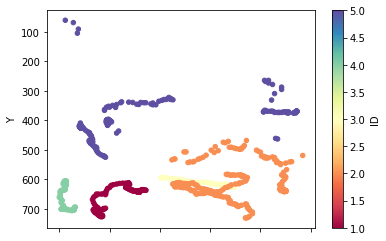

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

cmap = cm.get_cmap('Spectral')
df[df['ID'].isin(['1', '2', '3', '4', '5'])].plot('X','Y',kind='scatter', c='ID', cmap=cmap, edgecolor=None)
plt.gca().invert_yaxis()

In [7]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("volleyball", {}, base_dir + '/image/output.json', base_dir + '/image')

In [11]:
ball_metadata = MetadataCatalog.get("volleyball")
dataset_dicts = DatasetCatalog.get("volleyball")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [39]:
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("volleyball",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")   # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ball)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/27 20:32:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[07/27 20:32:14 d2.engine.train_loop]: Starting training from iteration 0
[07/27 20:32:42 d2.utils.events]:  eta: 0:23:35  iter: 19  total_loss: 1.144  loss_cls: 0.853  loss_box_reg: 0.010  loss_rpn_cls: 0.228  loss_rpn_loc: 0.020  time: 1.4441  data_time: 0.0197  lr: 0.000005  max_mem: 2795M
[07/27 20:33:11 d2.utils.events]:  eta: 0:23:08  iter: 39  total_loss: 1.083  loss_cls: 0.768  loss_box_reg: 0.005  loss_rpn_cls: 0.241  loss_rpn_loc: 0.023  time: 1.4387  data_time: 0.0064  lr: 0.000010  max_mem: 2795M
[07/27 20:33:41 d2.utils.events]:  eta: 0:23:00  iter: 59  total_loss: 0.895  loss_cls: 0.611  loss_box_reg: 0.009  loss_rpn_cls: 0.229  loss_rpn_loc: 0.025  time: 1.4503  data_time: 0.0064  lr: 0.000015  max_mem: 2795M
[07/27 20:34:09 d2.utils.events]:  eta: 0:22:21  iter: 79  total_loss: 0.695  loss_cls: 0.443  loss_box_reg: 0.012  loss_rpn_cls: 0.196  loss_rpn_loc: 0.025  time: 1.4464  data_time: 0.0064  lr: 0.000020  max_mem: 2795M
[07/27 20:34:38 d2.utils.events]:  eta: 0:21:4

In [40]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("volleyball", )
predictor = DefaultPredictor(cfg)

In [43]:
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer


cap = cv2.VideoCapture(base_dir + '/MBVF M7 S3.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
videoOut = cv2.VideoWriter(base_dir + '/ball_tracker.mp4', fourcc,
                           frames_per_second, (width, height))

v = VideoVisualizer(ball_metadata, ColorMode.IMAGE)

for ix in tqdm(range(int(60 * frames_per_second))):
    ret, frame = cap.read()
    outputs = predictor(frame)

    out = v.draw_instance_predictions(frame, outputs["instances"].to("cpu"))
    # out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

    # visualization = v.draw_instance_predictions(frame_poly, outputs["instances"].to("cpu"))
    # frame_poly = visualization.get_image()

    videoOut.write(out.get_image())

videoOut.release()
cap.release()

100%|██████████| 1686/1686 [13:00<00:00,  2.16it/s]


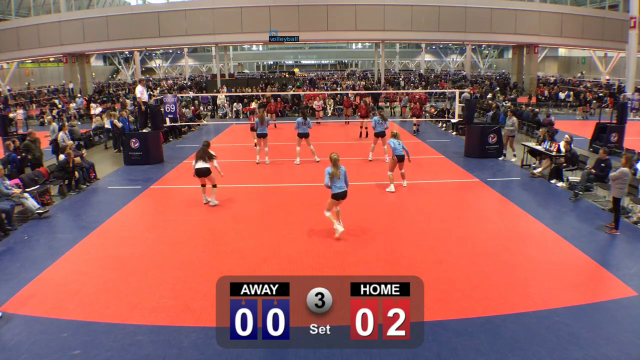

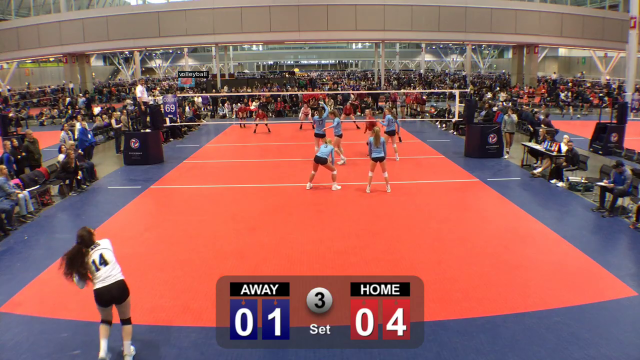

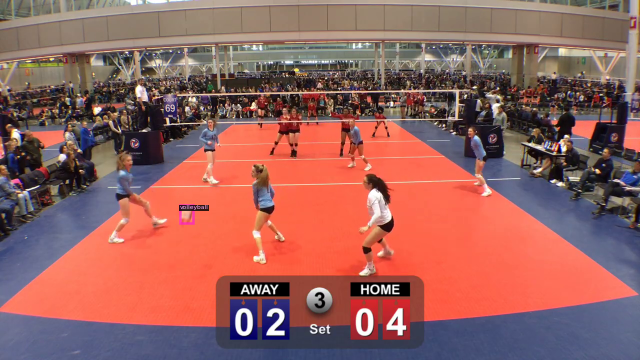

In [28]:
for d in random.sample(dataset_dicts, 3):
   img = cv2.imread(d["file_name"])
   visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata,    scale=0.5)
   out = visualizer.draw_dataset_dict(d)
   cv2_imshow(out.get_image()[:, :, ::-1])

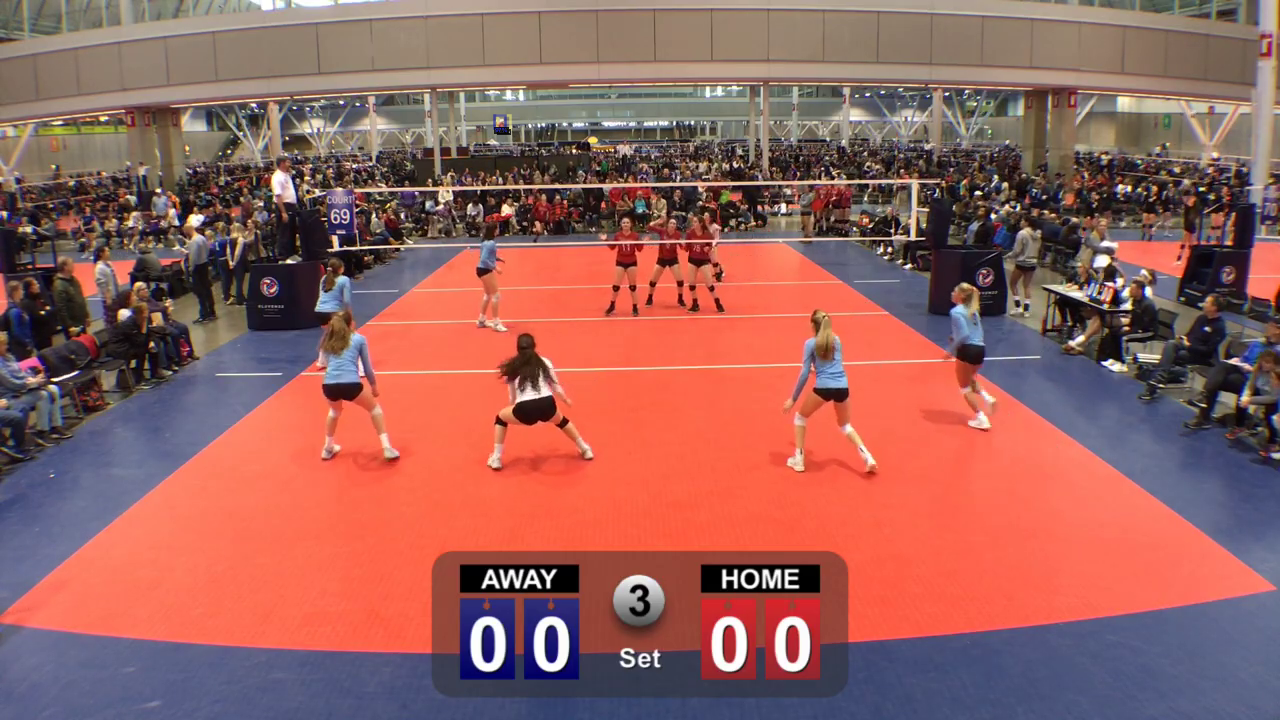

In [41]:
im = cv2.imread(base_dir + '/image/2.png')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
  metadata=ball_metadata,
  scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])